In [42]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import log_likelihood
from pgmpy.estimators.CITests import chi_square
import time

In [2]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [3]:
df = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
df

,PULMEMBOLUS,PAP,KINKEDTUBE,INTUBATION,MINVOLSET,VENTMACH,DISCONNECT,VENTTUBE,VENTLUNG,SHUNT,...,CO,BP,EXPCO2,ERRLOWOUTPUT,PRESS,HRBP,MINVOL,HISTORY,HRSAT,PCWP
1,1,1,0,1,2,2,1,3,3,0,...,1,1,1,0,0,0,3,0,0,2
2,0,2,0,1,2,2,0,1,3,1,...,0,0,1,1,1,2,3,0,0,2
3,0,2,0,2,2,2,0,1,1,0,...,0,0,2,0,0,0,1,0,0,2
4,0,2,0,1,2,2,0,1,3,1,...,1,1,1,0,0,0,3,1,2,1
5,0,2,0,1,2,2,0,1,3,1,...,0,0,1,0,1,1,3,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0,2,1,1,2,2,0,1,3,1,...,1,1,1,0,1,0,3,0,0,0
9997,0,0,0,1,2,2,0,1,3,1,...,0,0,1,0,2,0,3,0,0,2
9998,0,2,0,0,0,0,0,0,2,1,...,0,0,2,0,0,0,3,0,0,2
9999,0,2,0,1,2,2,0,1,3,1,...,1,1,1,0,1,0,3,0,0,0


### chi-squared test

In [16]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### Sorting Functions

In [5]:
def create_permutations(my_list):
    '''
    takes in a list, remove extra permutations from the list and only creates a pair of permutations
    '''
    p_permutations = []
    new_list = list(set(tuple(sorted(l[:2])) for l in my_list))
    for items in new_list:
        new_list_0 = list(itertools.permutations(items[:2],2))[1]
        p_permutations.append(new_list_0)
    return new_list + p_permutations

In [6]:
#given 2 lists, append them together and remove duplicates
def remove_permutations(list_):
    '''
    returns a sorted list without permutation
    '''
    return sorted(list(set(tuple(sorted(l[:2])) for l in list_)))

### CONDITIONAL MAIN CODE

In [7]:
#1st order CI
def cond_1_generate(df):
    v = list(df)
    p_permutations = list(itertools.permutations(v,3))
    order_0 = create_permutations(chi2bool(df)[0])
    generated = [x for x in p_permutations if x[:2] not in order_0]
    generated_0 = set(tuple(sorted(items[:2])) for items in generated)
    generate_return = [x for x in generated if x[:2] in generated_0]
    return generate_return

In [8]:
def cond_1_test(df):
    chi2_data = []
    phi = cond_1_generate(df)
    for i,j,k in phi:
        chi2 = chi_square(X=i, Y=j, Z=[k], data=df, significance_level=0.05)
        chi2_data.append((i,j,k,chi2))
    true_list = [x for x in chi2_data if True in x]
    false_list = [x for x in chi2_data if False in x]
    return true_list, false_list

In [27]:
def PC(df, n, rho):
    '''
    Note:
    This function will start from at least 0th order CI
    
    Parameters:
    df (pandas dataframe)
    n, an integer <= the length of list(df)
    rho (the significance level, only accepts values between 0 and 1 inclusive)
    
    Returns:
    A list which contains every independent X and Y
    '''
    N = 3
    v = list(df)
    # remove_list = [x for x in p_permute]
    remove_list = create_permutations([x[:2] for x in chi2bool(df, rho)[0]]) #x[:2] for 0th order and its permutations
    empty_list = []
    while N <= n:
        list_permutations = [x for x in itertools.permutations(v, N) if x[:2] not in remove_list]
        p_1 = [x[:1] for x in list_permutations]
        p_2 = [x[1:2] for x in list_permutations]
        p = [x[2:] for x in list_permutations]
        for i,j,k in zip(p_1, p_2, p):
            chi2 = chi_square(X=i[0], Y=j[0], Z=k, data=df, significance_level=rho)
            empty_list.append((i[0],j[0],k,chi2))
        true_list = create_permutations([x[:2] for x in empty_list if True in x])
        remove_list = remove_list + create_permutations(true_list)
        remove_list = create_permutations(remove_list)
        N += 1
        
    return remove_permutations(remove_list)
#nP3 takes 2minutes to run
#nP4 takes 9-15minutes to run
#nP5 takes ??? minutes to run
#nP6 not doable

In [106]:
tic = time.time()
n_edges = []
for i in np.linspace(0.0, 1.0, 11):
    n_ = PC(df, 3, i)
    print(len(n_))
    n_edges.append(len(n_))
toc = time.time()

666
589
579
568
546
533
508
467
412
324
20


In [107]:
time_taken = toc - tic
time_taken

3195.412442445755

In [108]:
import matplotlib.pyplot as plt

In [113]:
n_edges

[666, 589, 579, 568, 546, 533, 508, 467, 412, 324, 20]

In [118]:
the_list = list(np.linspace(0.0,1.0,11))

Text(0, 0.5, 'number of edges removed')

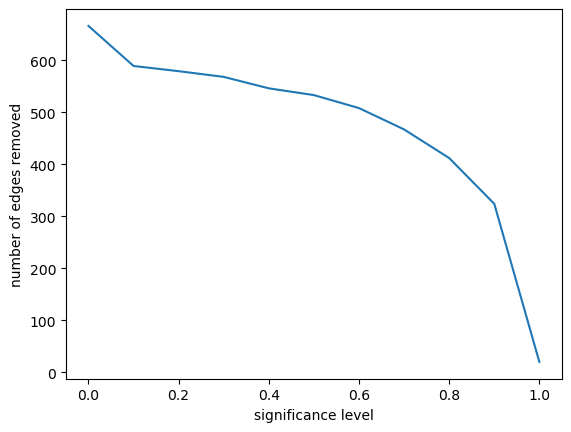

In [122]:
plt.plot(the_list, n_edges, marker='')
plt.xlabel('significance level')
plt.ylabel('number of edges removed')

In [55]:
%%time
y0 = PC(df, 3, 0.05)

CPU times: total: 2min 20s
Wall time: 2min 21s


In [96]:
m = Gobnilp()

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0


**********
BN has score -105226.51191678003
**********
ANAPHYLAXIS<- -578.587070487134
ARTCO2<-VENTALV -1816.018107669981
VENTALV<-INTUBATION,VENTLUNG -1785.1568955858384
BP<-CO,TPR -4927.804606748883
CO<-HR,STROKEVOLUME -2678.9117199075117
TPR<-ANAPHYLAXIS -10794.813215814676
CATECHOL<-ARTCO2,TPR -1521.301873422577
HR<-CATECHOL -3744.599767304855
STROKEVOLUME<-HYPOVOLEMIA,LVFAILURE -4437.288938131547
CVP<-LVEDVOLUME -3006.615302132195
LVEDVOLUME<-HYPOVOLEMIA,LVFAILURE -3613.5057310384145
DISCONNECT<- -3295.031743080661
ERRCAUTER<- -3222.5768222310726
ERRLOWOUTPUT<- -1972.2788189759885
EXPCO2<-ARTCO2,VENTLUNG -1772.659127224848
VENTLUNG<-INTUBATION,KINKEDTUBE,VENTTUBE -3618.0085247885727
FIO2<- -1888.628670533668
HISTORY<-LVFAILURE -637.4903136947833
LVFAILURE<- -2010.5432102550985
HRBP<-ERRLOWOUTPUT,HR -1331.6218853034952
HREKG<-ERRCAUTER,HR -1507.9736736634222
HRSAT<-ERRCAUTER,HR -1452.0851029207115
HYPOVOLEMIA<- -4990.780506105162
INSUFFANESTH<- -3303.7325344726705
INTUBATION<- -342

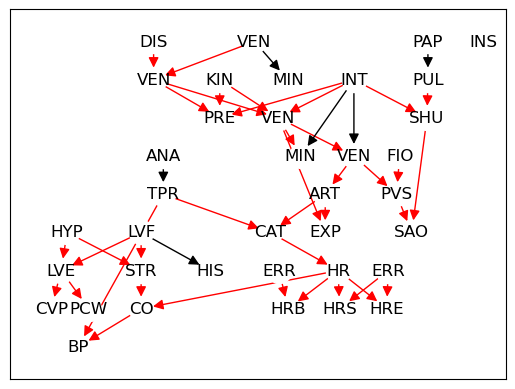

CPU times: total: 10min 5s
Wall time: 3min 10s


In [97]:
%%time
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat')

In [100]:
for i,j in y0:
    m.add_forbidden_arrow(i,j)

**********
BN has score -105226.51191678003
**********
ANAPHYLAXIS<- -578.587070487134
ARTCO2<-VENTALV -1816.018107669981
VENTALV<-INTUBATION,VENTLUNG -1785.1568955858384
BP<-CO,TPR -4927.804606748883
CO<-HR,STROKEVOLUME -2678.9117199075117
TPR<-ANAPHYLAXIS -10794.813215814676
CATECHOL<-ARTCO2,TPR -1521.301873422577
HR<-CATECHOL -3744.599767304855
STROKEVOLUME<-HYPOVOLEMIA,LVFAILURE -4437.288938131547
CVP<-LVEDVOLUME -3006.615302132195
LVEDVOLUME<-HYPOVOLEMIA,LVFAILURE -3613.5057310384145
DISCONNECT<- -3295.031743080661
ERRCAUTER<- -3222.5768222310726
ERRLOWOUTPUT<- -1972.2788189759885
EXPCO2<-ARTCO2,VENTLUNG -1772.659127224848
VENTLUNG<-INTUBATION,KINKEDTUBE,VENTTUBE -3618.0085247885727
FIO2<- -1888.628670533668
HISTORY<-LVFAILURE -637.4903136947833
LVFAILURE<- -2010.5432102550985
HRBP<-ERRLOWOUTPUT,HR -1331.6218853034952
HREKG<-ERRCAUTER,HR -1507.9736736634222
HRSAT<-ERRCAUTER,HR -1452.0851029207115
HYPOVOLEMIA<- -4990.780506105162
INSUFFANESTH<- -3303.7325344726705
INTUBATION<- -342

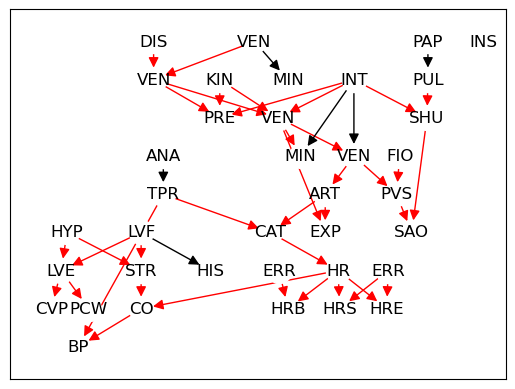

CPU times: total: 391 ms
Wall time: 435 ms


In [101]:
%%time
m.learn(start='MIP solution')

In [102]:
my_list = m.obligatory_conditional_independences

In [103]:
my_list

set()

In [75]:
new_l = [x for x in my_list if x not in y0]
new_l

[('ANAPHYLAXIS', 'TPR'),
 ('ARTCO2', 'CATECHOL'),
 ('ARTCO2', 'EXPCO2'),
 ('ARTCO2', 'VENTALV'),
 ('BP', 'ANAPHYLAXIS'),
 ('BP', 'ARTCO2'),
 ('BP', 'CATECHOL'),
 ('BP', 'CO'),
 ('BP', 'HISTORY'),
 ('BP', 'HR'),
 ('BP', 'STROKEVOLUME'),
 ('BP', 'TPR'),
 ('CATECHOL', 'ANAPHYLAXIS'),
 ('CATECHOL', 'ARTCO2'),
 ('CATECHOL', 'BP'),
 ('CATECHOL', 'HR'),
 ('CATECHOL', 'HRSAT'),
 ('CATECHOL', 'MINVOL'),
 ('CATECHOL', 'SAO2'),
 ('CATECHOL', 'TPR'),
 ('CO', 'ARTCO2'),
 ('CO', 'BP'),
 ('CO', 'CATECHOL'),
 ('CO', 'HR'),
 ('CO', 'STROKEVOLUME'),
 ('CVP', 'BP'),
 ('CVP', 'CO'),
 ('CVP', 'LVEDVOLUME'),
 ('CVP', 'PCWP'),
 ('DISCONNECT', 'ARTCO2'),
 ('DISCONNECT', 'CATECHOL'),
 ('DISCONNECT', 'CO'),
 ('DISCONNECT', 'VENTTUBE'),
 ('ERRCAUTER', 'CATECHOL'),
 ('ERRCAUTER', 'CO'),
 ('ERRCAUTER', 'HREKG'),
 ('ERRCAUTER', 'HRSAT'),
 ('ERRLOWOUTPUT', 'CATECHOL'),
 ('ERRLOWOUTPUT', 'CO'),
 ('ERRLOWOUTPUT', 'ERRCAUTER'),
 ('ERRLOWOUTPUT', 'HRBP'),
 ('EXPCO2', 'ARTCO2'),
 ('EXPCO2', 'CATECHOL'),
 ('EXPCO2', 'DISC